In [2]:
import pandas

dataset = pandas.read_table("ICPSR_37692/DS0001/37692-0001-Data.tsv", low_memory=False)

In [3]:
''' Read in data needed for the ORR '''

state_lgbt = pandas.read_csv("pop_counts/lbgt_percent_by_state.csv")

#state_pops = pandas.read_csv("pop_counts/state_pops.csv")

state_incs = pandas.read_csv("pop_counts/total_incarcerated_by_state.csv")

In [4]:
def remove_indet(frame, variable_name, keep_dontknow=False, dontknow_signal="-1"):
    ''' 
    Removes entries from the dataframe for which the given variables has a negative, indeterminate value.
    When keep_dontknow is true, it preserves entries for which the value was "-1", which is used in the data as a generic
    "don't know" signal. That operation does not preserve order.
    '''
    neg_mask = frame[f'{variable_name}'].str[0] == "-"
    if keep_dontknow:
        frame1 = frame.query('not @neg_mask')
        frame2 = frame.query(f'{variable_name} == "{dontknow_signal}"')
        frame = pandas.concat([frame1, frame2])
    else:
        frame = frame.query('not @neg_mask')

    return frame
    

In [5]:
'''Select only self-identified transgender people.'''

trans_data = dataset.query('V1212 == "3"')

First, we will cut the data into sets for specific interest groups.

In [6]:
'''
Select only data on non-straight people. This excludes V1213 answer 2, 
and also people who failed to indicate sexual orientation.

I include people who reported that they did not know their sexual orientation,
either via the -1 "Don't Know" error coding or the 5 "You don't know the answer."
This should allow for questioning people to be included as well.
'''

lgbq_data = dataset.query('V1213 != "2"') 
lgbq_data = remove_indet(lgbq_data, "V1213", keep_dontknow=True)

In [7]:
'''
Select 'assigned gender non-conforming' people. I define this to mean people whose assigned sex at birth does not match
their gender, regardless of transgender identification.
'''

agnc_data = dataset.query('V1211 != V1212')
agnc_data = remove_indet(agnc_data, 'V1211')
agnc_data = remove_indet(agnc_data, 'V1212', keep_dontknow=True)

In [30]:
print(len(dataset))
print(len(trans_data))
print(len(lgbq_data))
print(len(agnc_data))


24848
31
2139
95


In [9]:
print(len(lgbq_data.query('V1213 == "3"')))

In [10]:
''' Interestingly, only about 1 in 3 ASNC people in this population chose to label themselves transgender. '''
len(trans_data)/len(agnc_data)

In [11]:
''' Merge into a dataset for all lgbtq people. '''
lgbtq_data = pandas.concat([lgbq_data, agnc_data]).drop_duplicates()
if PRINT_SAMPLE_SIZES:
    len(lgbtq_data)

In [26]:
''' Total LGBTQ rate was 8.7%, markedly higher than the US rate (~3.7%). '''
if PRINT_EARLY_STATS:
    len(lgbtq_data) / len(dataset)

In [27]:
''' 
71% of LGBTQ respondants identified as female, but only 
25% of the total population did. 
'''

m = len(lgbtq_data.query("V1212 == '1'"))
f = len(lgbtq_data.query("V1212 == '2'"))
print(f / (m+f))

m = len(dataset.query("V1212 == '1'"))
f = len(dataset.query("V1212 == '2'"))
print(f / (m+f))

0.7140672782874617
0.2530443253774963


Seperate these datasets by state.

In [14]:
''' A list of all state codes present in the dataset. Invalid codes are removed. '''
list_state_codes = ['FL', 'MD', 'PA', 'NM', 'KY', 'MA', 'OR', 'WV', 'WI', 'WA', 'MI', 'CA', 'IL', 'VA', 'DE', 'NY', 'NV', 'SD', 'LA', 'UT', 'TX', 'MN', 'MO', 'SC', 'GA', 'NC', 'TN', 'IA', 'OH', 'IN', 'CT', 'MS', 'AR', 'HI', 'OK', 'NJ', 'ID', 'AZ', 'VT', 'NE', 'CO', 'AK', 'AL', 'KS', 'ND', 'RI', 'NH', 'WY', 'MT', 'ME']
# PR, DC removed because of data issues

In [15]:
''' 
Remove states with too few responses. 
For now I'll say that a state has too few responses when each contributes
more than 1% of the total, i.e. when there are fewer than 100 responses,
or when their response ratio is less than 0.25%
'''

true_list_state_codes = []

print("Removing states with n < 100 or rr < 0.0025:")
for state in list_state_codes:
    N = len(dataset.query(f"V0772 == '{state}'")) 
    I = int(state_incs.query(f'State == "{state}"')['Incarcerated'])
    if N < 100 or (N/I) < 0.0025:
        print(state)
    else:
        true_list_state_codes.append(state)

list_state_codes = true_list_state_codes
print(f"There are {len(list_state_codes)} states left in the sample.")


Removing states with n < 100 or rr < 0.0025:
KY
WA
DE
UT
MN
NJ
ID
VT
CO
ND
RI
NH
WY
MT
ME
There are 35 states left in the sample.


In [16]:
def cut_by_state(frame):
    ''' Divide a dataframe into a dictionary of dataframes by state the inmate was living in at the time of arrest. '''
    statewise_dict = {}
    for state in list_state_codes:
        subset = frame.query(f'V0772 == "{state}"')
        statewise_dict[state] = subset
        
    return statewise_dict
        

In [17]:
lgbtq_bs = cut_by_state(lgbtq_data)

In [18]:
''' Count responses after pruning. '''
if PRINT_SAMPLE_SIZES:
    s = 0
    ls = 0
    for state in list_state_codes:
        s += len(dataset.query(f'V0772 == "{state}"'))
        ls += len(lgbtq_bs[state])

    print(s)
    print(ls)
    

Calculate the LGBTQ overrepresentation index for each state.

The OverRepresentation Ratio is meant to measure how much more likely an LGBTQ person is to be incarcerated in a given
state than a member of the general population. It's made of the following factors:

In [19]:
'''OverRepresentation Ratio, measures proportion of 
LGBTQ prisoners in sample to ordinary prisoners.

Note that these values are unweighted, and so must be used with care. 

a - number self-reported lgbtq people in sample in state
N - number sampled in state
L - estimated proportion lgbtq in state

o = (a/N) / L

'''

orr_bs = {}
vars_bs = {}

sample_min = 20

for state in list_state_codes:
    a = len(lgbtq_bs[state])
    L = float(state_lgbt.query(f'State == "{state}"')['Estimated Percent LGBT']) / 100
    I = int(state_incs.query(f'State == "{state}"')['Incarcerated'])
    #P = int(state_pops.query(f'Label == "{state}"')['Total'])
    N = len(dataset.query(f'V0772 == "{state}"'))
    
    if N < sample_min or a == 0:
        a = 0
    else:
        vars_bs[f'{state}'] = [(a/N), L, ((a/N) / L),(N/I)]
    
    orr_bs[f'{state}'] = (a/N) / L
    

In [20]:
rep_plot_frame = pandas.DataFrame.from_dict(vars_bs, orient='index', columns = ['incar', 'general', 'orr', 'rratio'])

<AxesSubplot:>

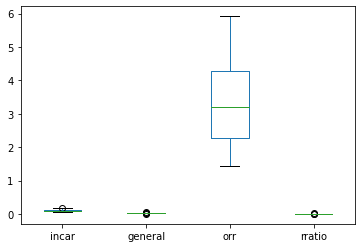

In [21]:
rep_plot_frame.plot.box()

<AxesSubplot:xlabel='general', ylabel='incar'>

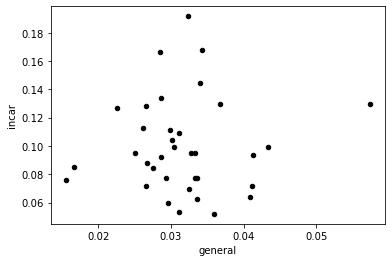

In [22]:
#rep_plot_frame.plot.scatter(x='general', y='incar', c='rratio', colormap='jet_r')
rep_plot_frame.plot.scatter(x='general', y='incar', c='black')

In [23]:
print(rep_plot_frame.sort_values('orr',axis='index', ascending=False))
print("\nMedians:")
print(rep_plot_frame.median())

       incar   general       orr    rratio
WV  0.191617  0.032366  5.920297  0.008308
NE  0.166667  0.028438  5.860606  0.004378
SD  0.126667  0.022599  5.605000  0.010000
AR  0.085165  0.016567  5.140549  0.005049
AK  0.075949  0.015501  4.899734  0.012248
NM  0.167513  0.034335  4.878807  0.006523
SC  0.128151  0.026607  4.816429  0.006919
OK  0.133721  0.028557  4.682599  0.004617
WI  0.112971  0.026108  4.327076  0.004756
IN  0.144404  0.034017  4.245109  0.003465
KS  0.094972  0.025060  3.789776  0.004649
LA  0.111562  0.029899  3.731303  0.004441
HI  0.129464  0.036723  3.525412  0.008145
CT  0.108844  0.031136  3.495741  0.004933
VA  0.104403  0.030108  3.467626  0.006625
TN  0.088129  0.026651  3.306793  0.004657
NC  0.098985  0.030416  3.254396  0.005278
AL  0.092010  0.028689  3.207195  0.004138
IA  0.084211  0.027575  3.053842  0.004069
MD  0.094808  0.032749  2.895000  0.004475
OH  0.095057  0.033279  2.856354  0.003225
MS  0.072000  0.026546  2.712304  0.007657
MO  0.07743